# Information Retrieval Project Group-T-29

## Authors:

Alexandru Ciutacu, s1032974

Roland Németh, s1033711

## Imports

In [1]:
# Installing Required Libraries
!pip install -r requirements.txt

#Importing Necessary Libraries
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Import libraries for information retrieval and text processing
import re
import ir_datasets
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import pytrec_eval
import gensim.downloader as api
from rank_bm25 import BM25Okapi

#Section 3: Setting Up Word Embeddings
word_vectors = api.load("word2vec-google-news-300")

#Downloading NLTK Resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


[nltk_data] Downloading package punkt to /home/alex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/alex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/alex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alex/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Helper Functions

In [2]:
def preprocess_corpus(dataset):
    # Initialize stemmer, lemmatizer, and English stop words
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    processed_corpus = {}

    # Process each document in the dataset
    for doc in dataset.docs_iter():
        text = f'{doc.title} {doc.abstract}'  # Combine title and abstract
        text_lower = text.lower()  # Convert to lower case
        tokens = word_tokenize(text_lower)  # Tokenization
        filtered_tokens = [token for token in tokens if token not in stop_words]  # Remove stopwords
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]  # Lemmatize tokens
        stemmed_tokens = [stemmer.stem(token) for token in lemmatized_tokens]  # Stem lemmatized tokens
        processed_corpus.update({doc.doc_id: stemmed_tokens})  # Save processed text

    return processed_corpus

def preprocess_query(query):
    # Initialize stemmer, lemmatizer, and English stop words
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    lower_query = query.lower()  # Convert query to lower case
    tokens = word_tokenize(lower_query)  # Tokenize query
    filtered_tokens = [token for token in tokens if token not in stop_words]  # Remove stopwords
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]  # Lemmatize tokens
    stemmed_tokens = [stemmer.stem(token) for token in lemmatized_tokens]  # Stem lemmatized tokens
    return stemmed_tokens

def retrieve_documents_round5(bm25, query, index_to_doc_id):
    results_dict = {}
    prepped_query = preprocess_query(query)  # Preprocess query
    doc_scores = bm25.get_scores(prepped_query)  # Get document scores from BM25
    for index, score in enumerate(doc_scores):
        results_dict.update({index_to_doc_id[index]: score})  # Map scores to document IDs
    return results_dict

def is_standard_word(word):
    return re.fullmatch(r'[a-z]+', word) is not None  # Check if word consists only of lowercase letters

def create_synonym_dict(dataset, word_vectors):
    # Create a "synonym dictionary
    query_syn = {}
    corona_words = frozenset(['coronavirus', 'sars-cov', 'covid', 'sars-cov-2', 'covid-19'])  # Set of COVID-19 related terms
    for query in dataset.queries_iter():
        for qt in word_tokenize(query.title.lower()):
            if qt not in query_syn.keys():
                sub_dict = {}
                if qt in corona_words:  # Special handling for COVID-19 terms
                    for cw in corona_words:
                        if cw != qt:
                            sub_dict.update({cw: 1})  # Assign similarity of 1 for COVID-19 terms
                if qt in word_vectors.key_to_index:
                    # Retrieve the top 100 most similar words
                    for similar_word, similarity in word_vectors.most_similar(qt, topn=100):
                        if is_standard_word(similar_word):
                            sub_dict.update({similar_word: similarity})  # Add similar words and their similarity scores
                query_syn.update({qt: sub_dict})
    return query_syn

def expand_query(query, syn_dict, threshold=0):
    # Naive expansion" of the query
    def get_related_words(word, syn_dict, threshold):
        related_words = set()
        if word in syn_dict.keys():
            # Return similar words from the synonym dictionary
            for similar_word, similarity in syn_dict[word].items():
                # Check for threshold
                if similarity >= threshold:
                    related_words.add(similar_word)
        return list(related_words)
    
    related_words = []
    for word in word_tokenize(query.lower()):
        related_words += get_related_words(word, syn_dict, threshold)  # Get related words for each word in query

    expanded_query = query + ' ' + ' '.join(set(related_words))  # Append related words to the query
    return expanded_query



def weighted_query_expansion(query, syn_dict, threshold=0, ratio=1):
    original_terms = word_tokenize(query.lower())
    expanded_query = []
    
    for term in original_terms:
        added_synonyms = 0
        if term in syn_dict.keys():
            for synonym, similarity in syn_dict[term].items():
                if similarity >= threshold:
                    expanded_query.append(synonym)  # Add synonym if it meets the threshold
                    added_synonyms += 1
        expanded_query.extend([term] * max(1, ratio * added_synonyms))  # Add original term weighted by number of synonyms
    
    return ' '.join(expanded_query)  # Return the expanded query


In [3]:
def precision_at_k(col, scores, qrels, k):
    # Calculate precision at rank k for a given column (col)
    total_sum = 0
    top_k_scores = scores[col].sort_values(ascending=False).iloc[:k]  # Get top k scores
    top_k_indices = top_k_scores.index  # Extract indices of top k scores
    for idx in top_k_indices:
        # Increment total_sum for relevant documents
        if idx in qrels[col].index:
            total_sum += 1 if qrels[col].loc[idx] == 2 else 0
    precision = total_sum / k  # Calculate precision
    return precision

def recall_at_k(col, scores, qrels, k):
    # Calculate recall at rank k for a given column (col)
    total_sum = 0
    top_k_scores = scores[col].sort_values(ascending=False).iloc[:k]  # Get top k scores
    top_k_indices = top_k_scores.index  # Extract indices of top k scores
    for idx in top_k_indices:
        # Increment total_sum for relevant documents
        if idx in qrels[col].index:
            total_sum += 1 if qrels[col].loc[idx] == 2 else 0
    recall = total_sum / qrels[col][qrels[col] == 2].count()  # Calculate recall
    return recall

def average_precision(scores, qrels):
    # Calculate average precision for each column in scores
    average_precision_values = {}
    for col in qrels.columns:
        sorted_scores = scores[col].sort_values(ascending=False)
        sorted_indices = sorted_scores.index
        relevant_retrieved = 0
        precision_sum = 0
        num_relevant = qrels[col].value_counts().get(2, 0)  # Count most relevant documents
        for rank, idx in enumerate(sorted_indices, start=1):
            if idx in qrels[col].index and qrels[col][idx] == 2:
                relevant_retrieved += 1
                precision_at_this_rank = precision_at_k(col, scores, qrels, rank)
                precision_sum += precision_at_this_rank
        ap = precision_sum / num_relevant if num_relevant > 0 else 0  # Calculate AP
        average_precision_values[col] = ap
    return average_precision_values

def MAP(ap):
    # Calculate Mean Average Precision (MAP)
    if isinstance(ap, pd.Series):
        return ap.mean()
    return pd.Series(ap).mean()

def DCG_at_k(col, scores, qrels, k):
    # Calculate Discounted Cumulative Gain (DCG) at rank k for a given column (col)
    top_k_scores = scores[col].sort_values(ascending=False).iloc[:k]
    top_k_indices = top_k_scores.index
    dcg = 0
    for rank, idx in enumerate(top_k_indices, start=1):
        if idx in qrels.index:
            gains = 1 if qrels[col].loc[idx] == 2 else 0
            discounts = np.log2(1 + rank)
            dcg += gains / discounts  # Calculate DCG
    return dcg

def NDCG_at_k(col, scores, qrels, k):
    # Calculate Normalized Discounted Cumulative Gain (NDCG) at rank k for a given column (col)
    dcg = DCG_at_k(col, scores, qrels, k)
    ideal_qrels = qrels.sort_values(by=col, ascending=False)
    ideal_ranking = scores.loc[ideal_qrels.index]
    ideal_ranking = ideal_ranking[col].sort_values(ascending=False).iloc[:k]
    
    idcg = 0  # Ideal DCG
    for i in range(k):
        gain = 1 if 1 < len(ideal_ranking) and ideal_qrels[col].iloc[i] == 2 else 0
        discount = np.log2(1 + i + 1)
        idcg += gain / discount
    ndcg = dcg / idcg if idcg > 0 else 0  # Calculate NDCG
    return ndcg


In [4]:
def rank_and_dump(file_name, dataset, bm25, idx2docids):
    #Ranks documents for each query in the dataset using the BM25 model and dumps the results to a JSON file.
    results = {}
    for query in dataset.queries_iter():
        original_query = query.title # Get query
        # Retrieve documents
        documents_scores = retrieve_documents_round5(bm25, original_query, idx2docids)
        results.update({query.query_id: documents_scores})

    # Save results
    with open(f'{file_name}.json', 'w', encoding ='utf8') as json_file:
        json.dump(results, json_file)
    
    print('Ranking done!')
    
    return None
        
def rank_and_dump_expanded(file_name, dataset, bm25, idx2docids, syn_dict, threshold=0,  mode='normal', ratio=1):
    #Ranks documents for each query in the dataset using BM25 with expanded queries and dumps the results to a JSON file.
    results = {}
    for query in dataset.queries_iter():
        # select mode - 'normal' is naive
        match mode:
            case 'normal':
                expanded_query = expand_query(query.title, syn_dict, threshold)
            case 'weighted':
                expanded_query = weighted_query_expansion(query.title, syn_dict, threshold, ratio)
            case _:
                print('Defaulting to \'normal\'')
                expanded_query = expand_query(query.title, syn_dict, threshold)

        scores = retrieve_documents_round5(bm25, expanded_query, idx2docids)
        results.update({query.query_id: scores})
    
    # Save results
    with open(f'{file_name}.json', 'w', encoding ='utf8') as json_file:
        json.dump(results, json_file)
    
    print('Ranking done!')
    
    return None
        
        
def eval_scores(input_file, qrel):
    #Evaluates the ranked results using standard IR metrics and dumps the evaluation to a JSON file.
        
    with open(f'{input_file}.json', mode='r', encoding='utf8') as file: 
        run = json.load(file)
        
    evaluator = pytrec_eval.RelevanceEvaluator(qrel, {'map_cut', 'ndcg_cut', 'recall', 'infAP', 'ndcg', 'map'})
     
    with open(f'{input_file}_eval.json', 'w', encoding ='utf8') as json_file:
        json.dump(evaluator.evaluate(run), json_file, indent=4)
    
    print('Evaluation done!')
    
    return None

In [5]:
def format_qrels4eval(dataset):
    #Get query relevance scores ready for evaluation.
    qrel_dict = {}
    for query in dataset.qrels_iter():
        try:
            qrel_dict[query.query_id].update({query.doc_id: query.relevance})
        except KeyError:
            qrel_dict.update({query.query_id: {query.doc_id: query.relevance}})
    return qrel_dict

## Dataset

In [2]:
# Loading Round 5
dataset_round5 = ir_datasets.load("cord19/trec-covid/round5")

### Preprocessing the dataset

In [7]:
# Preparing the corpus for round 5
# Run this once
corpus_round5 = preprocess_corpus(dataset_round5)

# Save preprocessed corpus
with open('preprocessed_round5.json', mode='w', encoding='utf8') as corpus:
    json.dump(corpus_round5, corpus, indent=4)

del corpus_round5


# Save preprocessed query relevances
with open('qrel4eval.json', mode='w', encoding='utf8') as qrels4eval:
    json.dump(format_qrels4eval(dataset_round5), qrels4eval, indent=4)


# Save Synonym dictionary  
with open('synonym_dict_google.json', mode='w', encoding='utf8') as syn_dict1:
    json.dump(create_synonym_dict(dataset_round5, word_vectors), syn_dict1, indent=4)
    

In [8]:
# Run after running the previous cell once
# Load necessary preprocessed files
with open('preprocessed_round5.json', mode='r', encoding='utf8') as corpus:
    corpus_round5 = json.load(corpus)
    
idx2docids, corpus_text = list(corpus_round5.keys()), list(corpus_round5.values())

del corpus_round5

# Query relevances
with open('qrel4eval.json', mode='r', encoding='utf8') as qrels4eval:
    qrel = json.load(qrels4eval)
    
# Synonym dictionary
with open('synonym_dict_google.json', mode='r', encoding='utf8') as syn_dict_file:
    syn_dict = json.load(syn_dict_file)

### Load corpus and initialize BM25

In [9]:
bm25_round5 = BM25Okapi(corpus=corpus_text) # Initialize BM25

## Run before experiments

## BM25 baseline

In [10]:
# Rank and save ranking scores
rank_and_dump('baseline_bm25_scores', dataset_round5, bm25_round5, idx2docids)

Ranking done!


In [11]:
# Evaluate and save scores
eval_scores('baseline_bm25_scores', qrel)

Evaluation done!


In [12]:
#scores for each query for bm25
evals = pd.read_json('baseline_bm25_scores_eval.json')
evals.loc[['recall_10', 'recall_20', 'ndcg_cut_10', 'ndcg_cut_20', 'infAP', 'map_cut_10', 'map_cut_20', 'ndcg', 'map']].mean(axis=1)

recall_10      0.026302
recall_20      0.036381
ndcg_cut_10    0.272039
ndcg_cut_20    0.244637
infAP          0.114182
map_cut_10     0.012690
map_cut_20     0.016425
ndcg           0.560995
map            0.114180
dtype: float64

## Query Expansion by Synonyms

In [13]:
google_syn_dict = pd.read_json('synonym_dict_google.json') # Load synonym prepared dictionary

google_syn_dict.head()

,coronavirus,origin,response,to,weather,changes,immunity,how,do,people,...,transmission,mental,health,dexamethasone,outcomes,children,school,reopening,post-infection,mrna
sars-cov-2,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sars-cov,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
covid-19,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
covid,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
coronaviruses,0.721654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


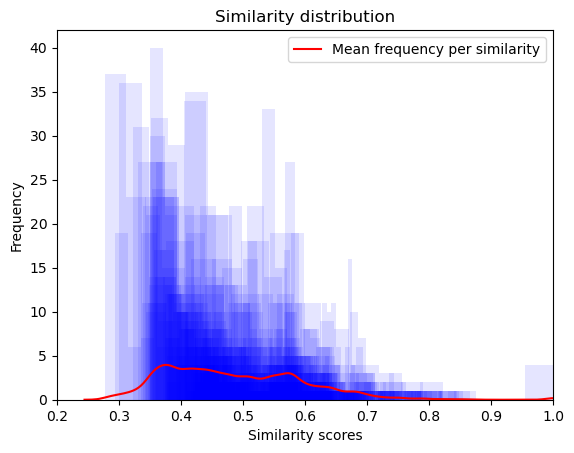

In [14]:
# Plot the similarity score discribution per word

plt.figure()
plt.title("Similarity distribution")
plt.xlabel("Similarity scores")
plt.ylabel("Frequency")
plt.xlim(0.2, 1)

all_scores = []
for col in google_syn_dict.columns:
    all_scores.extend(google_syn_dict[col].dropna())

for col in google_syn_dict:
    data = google_syn_dict[str(col)].dropna()
    if not data.empty:
        plt.hist(data, bins = 10, alpha = 0.1, color = 'blue')
        
sns.kdeplot(all_scores, bw_adjust = 0.5, color = 'red', label='Mean frequency per similarity')
plt.legend()
plt.show()

### Naive Query Expansion 0 Threshold

In [15]:
with open('synonym_dict_google.json', mode='r', encoding='utf8') as syn_dict_file:
    syn_dict = json.load(syn_dict_file)

In [1]:
# Rank and save ranking scores
rank_and_dump_expanded('normal_expanded_0_threshold', dataset_round5, bm25_round5, idx2docids, syn_dict)

NameError: name 'rank_and_dump_expanded' is not defined

In [17]:
# Evaluate and save scores
eval_scores('normal_expanded_0_threshold', qrel)

Evaluation done!


In [18]:
evals = pd.read_json('normal_expanded_0_threshold_eval.json')
evals.loc[['recall_10', 'recall_20', 'ndcg_cut_10', 'ndcg_cut_20', 'infAP', 'map_cut_10', 'map_cut_20', 'ndcg', 'map']].mean(axis=1)

recall_10      0.002118
recall_20      0.005173
ndcg_cut_10    0.060980
ndcg_cut_20    0.064788
infAP          0.035822
map_cut_10     0.001214
map_cut_20     0.002104
ndcg           0.454821
map            0.035822
dtype: float64

### Naive Query Expansion 0.35 Threshold

In [19]:
# Rank and save ranking scores
rank_and_dump_expanded('normal_expanded_35_threshold', dataset_round5, bm25_round5, idx2docids, syn_dict, threshold=0.35)

Ranking done!


In [20]:
# Evaluate and save scores
eval_scores('normal_expanded_35_threshold', qrel)

Evaluation done!


In [21]:
evals = pd.read_json('normal_expanded_35_threshold_eval.json')
evals.loc[['recall_10', 'recall_20', 'ndcg_cut_10', 'ndcg_cut_20', 'infAP', 'map_cut_10', 'map_cut_20', 'ndcg', 'map']].mean(axis=1)

recall_10      0.002171
recall_20      0.005327
ndcg_cut_10    0.061466
ndcg_cut_20    0.066006
infAP          0.036077
map_cut_10     0.001211
map_cut_20     0.002123
ndcg           0.455480
map            0.036077
dtype: float64

### Naive Query Expansion 0.6 Threshold

In [22]:
# Rank and save ranking scores
rank_and_dump_expanded('normal_expanded_60_threshold', dataset_round5, bm25_round5, idx2docids, syn_dict, threshold=0.6)

Ranking done!


In [23]:
# Evaluate and save scores
eval_scores('normal_expanded_60_threshold', qrel)

Evaluation done!


In [24]:
evals = pd.read_json('normal_expanded_60_threshold_eval.json')
evals.loc[['recall_10', 'recall_20', 'ndcg_cut_10', 'ndcg_cut_20', 'infAP', 'map_cut_10', 'map_cut_20', 'ndcg', 'map']].mean(axis=1)

recall_10      0.007930
recall_20      0.015830
ndcg_cut_10    0.085482
ndcg_cut_20    0.096886
infAP          0.058968
map_cut_10     0.002906
map_cut_20     0.005182
ndcg           0.480546
map            0.058966
dtype: float64

## Weighthed expanded query

### 1-to-1 Weighted Expanded Query 0 threshold

In [25]:
# Rank and save ranking scores
rank_and_dump_expanded('weighted_1-to-1_expanded_0_threshold', dataset_round5, bm25_round5, idx2docids, syn_dict, threshold=0, mode='weighted', ratio=1)

Ranking done!


In [26]:
# Evaluate and save scores
eval_scores('weighted_1-to-1_expanded_0_threshold', qrel)

Evaluation done!


In [31]:
evals = pd.read_json('weighted_1-to-1_expanded_0_threshold_eval.json')
evals.loc[['recall_10', 'recall_20', 'ndcg_cut_10', 'ndcg_cut_20', 'infAP', 'map_cut_10', 'map_cut_20', 'ndcg', 'map']].mean(axis=1)

recall_10      0.021112
recall_20      0.032046
ndcg_cut_10    0.218789
ndcg_cut_20    0.199794
infAP          0.092303
map_cut_10     0.009581
map_cut_20     0.013804
ndcg           0.537146
map            0.092301
dtype: float64

### 1-to-1 Weighted Expanded Query 0.35 threshold

In [32]:
# Rank and save ranking scores
rank_and_dump_expanded('weighted_1-to-1_expanded_35_threshold', dataset_round5, bm25_round5, idx2docids, syn_dict, threshold=0.35, mode='weighted', ratio=1)

Ranking done!


In [33]:
# Evaluate and save scores
eval_scores('weighted_1-to-1_expanded_35_threshold', qrel)

Evaluation done!


In [35]:
evals = pd.read_json('weighted_1-to-1_expanded_35_threshold_eval.json')
evals.loc[['recall_10', 'recall_20', 'ndcg_cut_10', 'ndcg_cut_20', 'infAP', 'map_cut_10', 'map_cut_20', 'ndcg', 'map']].mean(axis=1)

recall_10      0.021155
recall_20      0.032231
ndcg_cut_10    0.220016
ndcg_cut_20    0.200999
infAP          0.092534
map_cut_10     0.009590
map_cut_20     0.013864
ndcg           0.537776
map            0.092532
dtype: float64

### 1-to-1 Weighted Expanded Query 0.6 threshold

In [36]:
# Rank and save ranking scores
rank_and_dump_expanded('weighted_1-to-1_expanded_60_threshold', dataset_round5, bm25_round5, idx2docids, syn_dict, threshold=0.6, mode='weighted', ratio=1)

Ranking done!


In [37]:
# Evaluate and save scores
eval_scores('weighted_1-to-1_expanded_60_threshold', qrel)

Evaluation done!


In [38]:
evals = pd.read_json('weighted_1-to-1_expanded_60_threshold_eval.json')
evals.loc[['recall_10', 'recall_20', 'ndcg_cut_10', 'ndcg_cut_20', 'infAP', 'map_cut_10', 'map_cut_20', 'ndcg', 'map']].mean(axis=1)

recall_10      0.020082
recall_20      0.029921
ndcg_cut_10    0.208221
ndcg_cut_20    0.190279
infAP          0.087873
map_cut_10     0.008807
map_cut_20     0.012704
ndcg           0.523476
map            0.087870
dtype: float64

### 2-to-1 Weighted Expanded Query 0 threshold

In [39]:
# Rank and save ranking scores
rank_and_dump_expanded('weighted_2-to-1_expanded_0_threshold', dataset_round5, bm25_round5, idx2docids, syn_dict, threshold=0, mode='weighted', ratio=2)

Ranking done!


In [40]:
# Evaluate and save scores
eval_scores('weighted_2-to-1_expanded_0_threshold', qrel)

Evaluation done!


In [41]:
evals = pd.read_json('weighted_2-to-1_expanded_0_threshold_eval.json')
evals.loc[['recall_10', 'recall_20', 'ndcg_cut_10', 'ndcg_cut_20', 'infAP', 'map_cut_10', 'map_cut_20', 'ndcg', 'map']].mean(axis=1)

recall_10      0.021301
recall_20      0.032399
ndcg_cut_10    0.217991
ndcg_cut_20    0.201024
infAP          0.091327
map_cut_10     0.009865
map_cut_20     0.014071
ndcg           0.535479
map            0.091326
dtype: float64

### 2-to-1 Weighted Expanded Query 0.35 threshold

In [42]:
# Rank and save ranking scores
rank_and_dump_expanded('weighted_2-to-1_expanded_35_threshold', dataset_round5, bm25_round5, idx2docids, syn_dict, threshold=0.35, mode='weighted', ratio=2)

Ranking done!


In [43]:
# Evaluate and save scores
eval_scores('weighted_2-to-1_expanded_35_threshold', qrel)

Evaluation done!


In [44]:
evals = pd.read_json('weighted_2-to-1_expanded_35_threshold_eval.json')
evals.loc[['recall_10', 'recall_20', 'ndcg_cut_10', 'ndcg_cut_20', 'infAP', 'map_cut_10', 'map_cut_20', 'ndcg', 'map']].mean(axis=1)

recall_10      0.021376
recall_20      0.032415
ndcg_cut_10    0.219507
ndcg_cut_20    0.201688
infAP          0.091588
map_cut_10     0.009974
map_cut_20     0.014208
ndcg           0.535997
map            0.091587
dtype: float64

### 2-to-1 Weighted Expanded Query 0.6 threshold

In [45]:
# Rank and save ranking scores
rank_and_dump_expanded('weighted_2-to-1_expanded_60_threshold', dataset_round5, bm25_round5, idx2docids, syn_dict, threshold=0.6, mode='weighted', ratio=2)

Ranking done!


In [46]:
# Evaluate and save scores
eval_scores('weighted_2-to-1_expanded_60_threshold', qrel)

Evaluation done!


In [47]:
evals = pd.read_json('weighted_2-to-1_expanded_60_threshold_eval.json')
evals.loc[['recall_10', 'recall_20', 'ndcg_cut_10', 'ndcg_cut_20', 'infAP', 'map_cut_10', 'map_cut_20', 'ndcg', 'map']].mean(axis=1)

recall_10      0.020272
recall_20      0.030473
ndcg_cut_10    0.213059
ndcg_cut_20    0.192323
infAP          0.085552
map_cut_10     0.009144
map_cut_20     0.013255
ndcg           0.518351
map            0.085549
dtype: float64

### 3-to-1 Weighted Expanded Query 0 threshold

In [48]:
# Rank and save ranking scores
rank_and_dump_expanded('weighted_3-to-1_expanded_0_threshold', dataset_round5, bm25_round5, idx2docids, syn_dict, threshold=0, mode='weighted', ratio=3)

Ranking done!


In [49]:
# Evaluate and save scores
eval_scores('weighted_3-to-1_expanded_0_threshold', qrel)

Evaluation done!


In [50]:
evals = pd.read_json('weighted_3-to-1_expanded_0_threshold_eval.json')
evals.loc[['recall_10', 'recall_20', 'ndcg_cut_10', 'ndcg_cut_20', 'infAP', 'map_cut_10', 'map_cut_20', 'ndcg', 'map']].mean(axis=1)

recall_10      0.023314
recall_20      0.032513
ndcg_cut_10    0.215131
ndcg_cut_20    0.201481
infAP          0.090938
map_cut_10     0.010973
map_cut_20     0.014351
ndcg           0.534281
map            0.090937
dtype: float64

### 3-to-1 Weighted Expanded Query 0.35 threshold

In [51]:
# Rank and save ranking scores
rank_and_dump_expanded('weighted_3-to-1_expanded_35_threshold', dataset_round5, bm25_round5, idx2docids, syn_dict, threshold=0.35, mode='weighted', ratio=3)

Ranking done!


In [52]:
# Evaluate and save scores
eval_scores('weighted_3-to-1_expanded_35_threshold', qrel)

Evaluation done!


In [53]:
evals = pd.read_json('weighted_3-to-1_expanded_35_threshold_eval.json')
evals.loc[['recall_10', 'recall_20', 'ndcg_cut_10', 'ndcg_cut_20', 'infAP', 'map_cut_10', 'map_cut_20', 'ndcg', 'map']].mean(axis=1)

recall_10      0.023451
recall_20      0.032403
ndcg_cut_10    0.216556
ndcg_cut_20    0.200837
infAP          0.091137
map_cut_10     0.011031
map_cut_20     0.014398
ndcg           0.534729
map            0.091136
dtype: float64

### 3-to-1 Weighted Expanded Query 0.6 threshold

In [54]:
# Rank and save ranking scores
rank_and_dump_expanded('weighted_3-to-1_expanded_60_threshold', dataset_round5, bm25_round5, idx2docids, syn_dict, threshold=0.6, mode='weighted', ratio=3)

Ranking done!


In [55]:
# Evaluate and save scores
eval_scores('weighted_3-to-1_expanded_60_threshold', qrel)

Evaluation done!


In [56]:
evals = pd.read_json('weighted_3-to-1_expanded_60_threshold_eval.json')
evals.loc[['recall_10', 'recall_20', 'ndcg_cut_10', 'ndcg_cut_20', 'infAP', 'map_cut_10', 'map_cut_20', 'ndcg', 'map']].mean(axis=1)

recall_10      0.020243
recall_20      0.030493
ndcg_cut_10    0.211183
ndcg_cut_20    0.189954
infAP          0.083552
map_cut_10     0.008779
map_cut_20     0.012797
ndcg           0.514246
map            0.083550
dtype: float64

## Formatting the results of all experiments

<Figure size 1200x600 with 0 Axes>

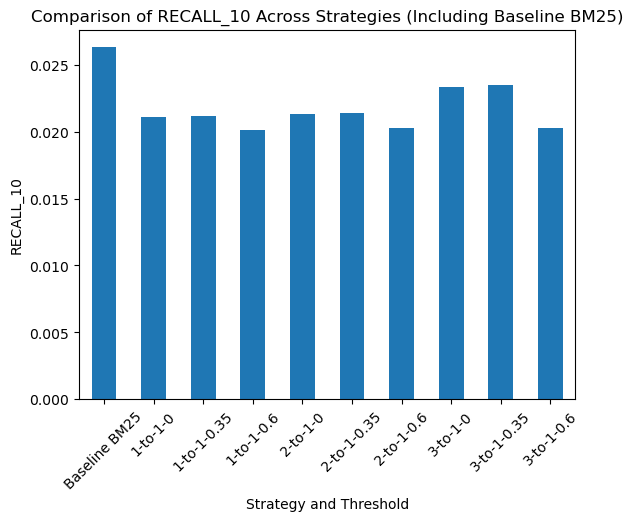

<Figure size 1200x600 with 0 Axes>

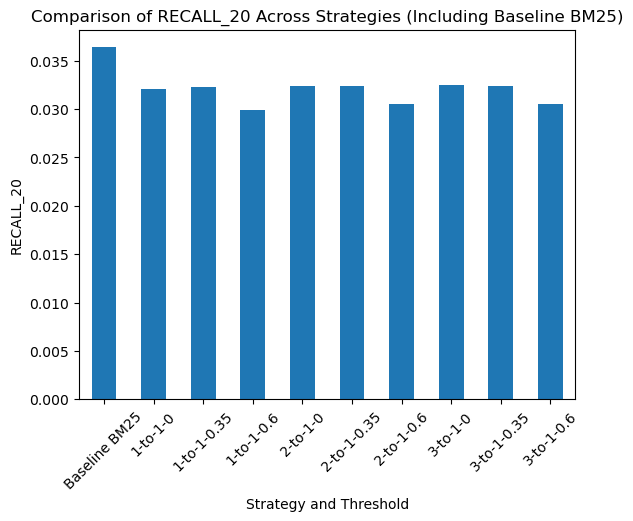

<Figure size 1200x600 with 0 Axes>

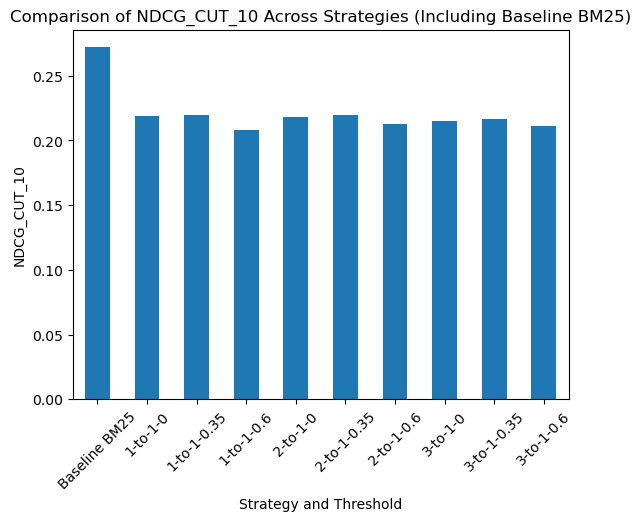

<Figure size 1200x600 with 0 Axes>

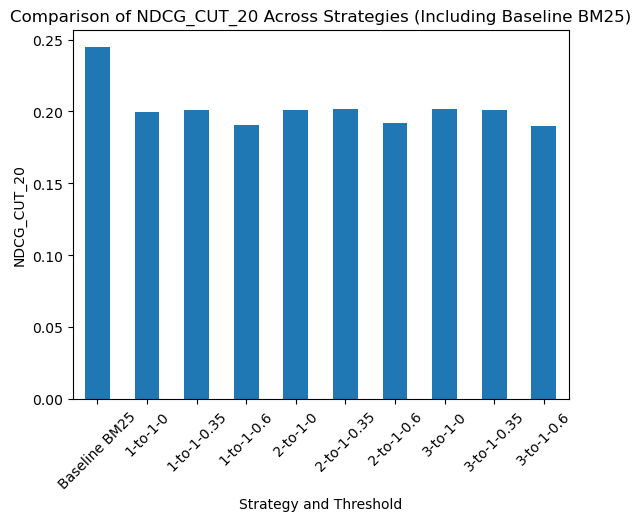

<Figure size 1200x600 with 0 Axes>

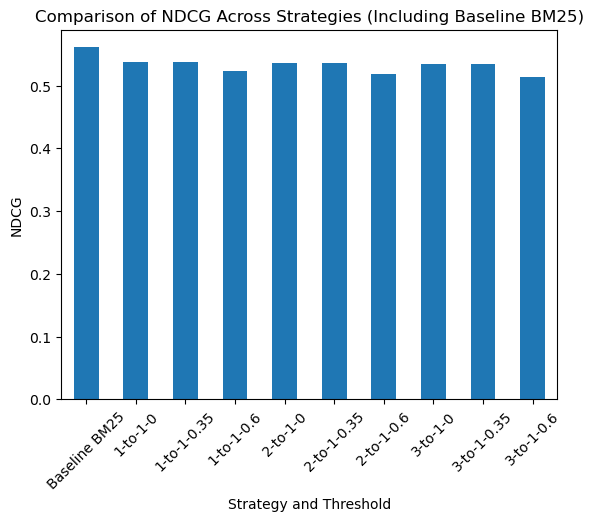

<Figure size 1200x600 with 0 Axes>

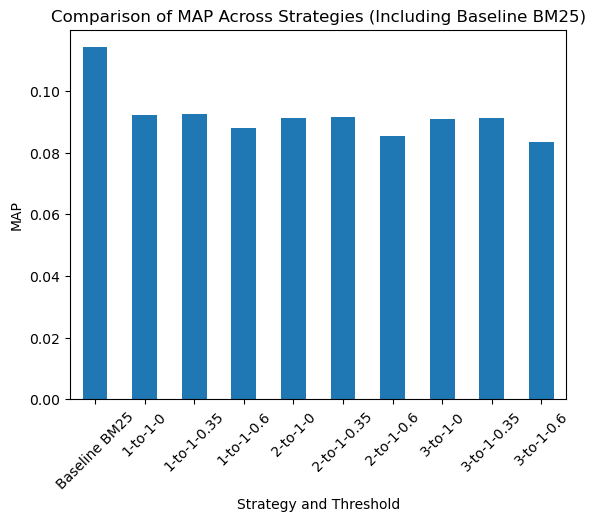

<Figure size 1200x600 with 0 Axes>

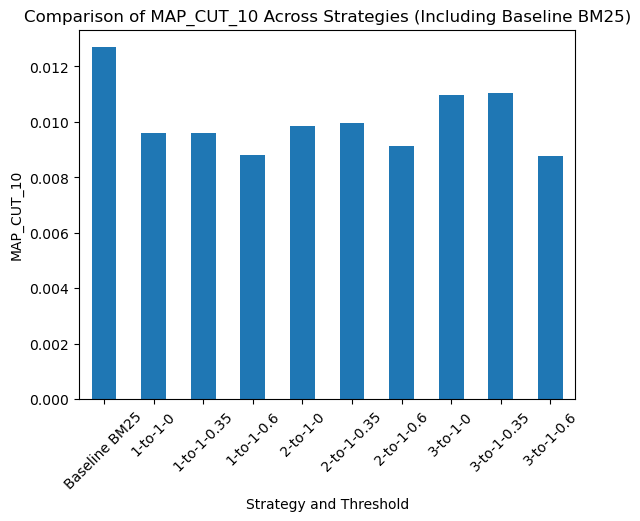

<Figure size 1200x600 with 0 Axes>

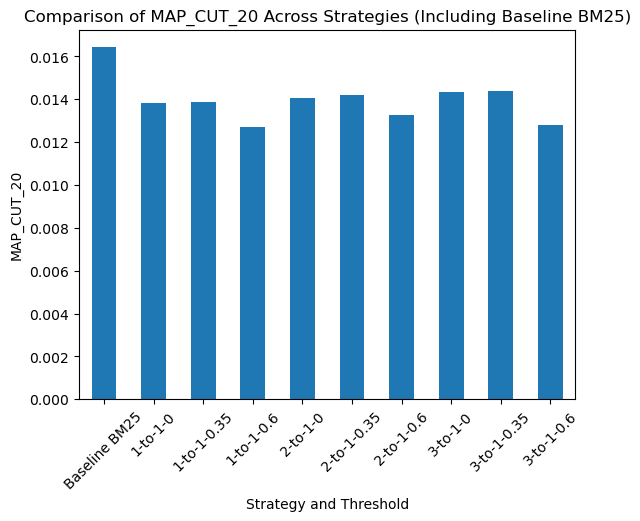

<Figure size 1200x600 with 0 Axes>

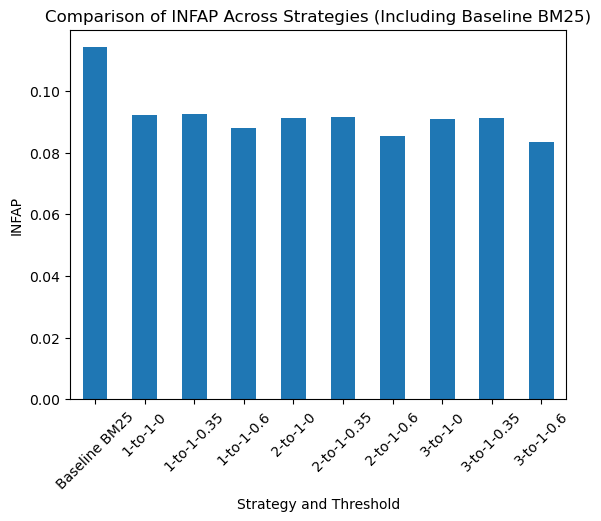

In [64]:
# Creating figures for the scores

# metrics and results of bm25 baseline
evals_bm25 = {
    'recall_10': 0.026302,
    'recall_20': 0.036381,
    'ndcg_cut_10': 0.272039,
    'ndcg_cut_20': 0.244637,
    'ndcg': 0.560995,
    'map': 0.114180,
    'map_cut_10': 0.012690,
    'map_cut_20': 0.016425,
    'infAP': 0.114182
}

# Results of the rest of the experiments
data = {
    'Strategy': ['Baseline BM25', '1-to-1-0', '1-to-1-0.35', '1-to-1-0.6', '2-to-1-0', '2-to-1-0.35', '2-to-1-0.6', '3-to-1-0', '3-to-1-0.35', '3-to-1-0.6'],
    'recall_10': [evals_bm25['recall_10'], 0.021112, 0.021155, 0.020082, 0.021301, 0.021376, 0.020272, 0.023314, 0.023451, 0.020243],
    'recall_20': [evals_bm25['recall_20'], 0.032046, 0.032231, 0.029921, 0.032399, 0.032415, 0.030473, 0.032513, 0.032403, 0.030493],
    'ndcg_cut_10': [evals_bm25['ndcg_cut_10'], 0.218789, 0.220016, 0.208221, 0.217991, 0.219507, 0.213059,  0.215131, 0.216556, 0.211183],
    'ndcg_cut_20': [evals_bm25['ndcg_cut_20'], 0.199794, 0.200999, 0.190279, 0.201024, 0.201688, 0.192323, 0.201481, 0.200837, 0.189954],
    'ndcg': [evals_bm25['ndcg'], 0.537146, 0.537776, 0.523476, 0.535479, 0.535997, 0.518351, 0.534281, 0.534729, 0.514246],
    'map_cut_10': [evals_bm25['map_cut_10'], 0.009581, 0.009590, 0.008807, 0.009865, 0.009974, 0.009144, 0.010973, 0.011031, 0.008779],
    'map_cut_20': [evals_bm25['map_cut_20'], 0.013804, 0.013864, 0.012704, 0.014071, 0.014208, 0.013255, 0.014351, 0.014398, 0.012797],
    'map': [evals_bm25['map'], 0.092301, 0.092532, 0.087870, 0.091326, 0.091587, 0.085549, 0.090937, 0.091136, 0.083550],
    'infAP': [evals_bm25['infAP'], 0.092303, 0.092534, 0.087873, 0.091327, 0.091588, 0.085552, 0.090938, 0.091137, 0.083552]
}
 
df = pd.DataFrame(data)

metrics = ['recall_10', 'recall_20', 'ndcg_cut_10', 'ndcg_cut_20', 'ndcg', 'map', 'map_cut_10','map_cut_20','infAP']

for metric in metrics:
    plt.figure(figsize=(12, 6))
    df.plot(x='Strategy', y=metric, kind='bar', legend=False)
    plt.title(f'Comparison of {metric.upper()} Across Strategies (Including Baseline BM25)')
    plt.ylabel(metric.upper())
    plt.xlabel('Strategy and Threshold')
    plt.xticks(rotation=45)
    plt.show()


In [4]:
# Find evaluation files

from glob import glob

file_names = glob('*_eval.json')

file_names

['baseline_bm25_scores_eval.json',
 'weighted_3-to-1_expanded_0_threshold_eval.json',
 'normal_expanded_60_threshold_eval.json',
 'weighted_1-to-1_expanded_35_threshold_eval.json',
 'weighted_1-to-1_expanded_0_threshold_eval.json',
 'weighted_2-to-1_expanded_60_threshold_eval.json',
 'weighted_3-to-1_expanded_35_threshold_eval.json',
 'weighted_3-to-1_expanded_60_threshold_eval.json',
 'weighted_2-to-1_expanded_35_threshold_eval.json',
 'normal_expanded_0_threshold_eval.json',
 'normal_expanded_35_threshold_eval.json',
 'weighted_2-to-1_expanded_0_threshold_eval.json',
 'weighted_1-to-1_expanded_60_threshold_eval.json']

In [16]:
import pandas as pd

# Create table of evaluation

eval_table = pd.DataFrame([])

metrics = ['recall_10', 'recall_20', 'ndcg_cut_10', 'ndcg_cut_20', 'map', 'map_cut_10','map_cut_20']
index = ['recall@10', 'recall@20', 'ndcg@10', 'ndcg@20', 'MAP', 'precision@10','precion@20']

headers = [fn.strip('_eval.json') for fn in file_names]

for fn in file_names:
    eval_table = pd.concat([eval_table, pd.read_json(fn).mean(axis=1).loc[metrics]], axis=1)
    
eval_table.columns = headers
eval_table.index = index

eval_table.transpose()

,recall@10,recall@20,ndcg@10,ndcg@20,MAP,precision@10,precion@20
baseline_bm25_scor,0.026302,0.036381,0.272039,0.244637,0.114180,0.012690,0.016425
weighted_3-to-1_expanded_0_threshold,0.023314,0.032513,0.215131,0.201481,0.090937,0.010973,0.014351
rmal_expanded_60_threshold,0.007930,0.015830,0.085482,0.096886,0.058966,0.002906,0.005182
weighted_1-to-1_expanded_35_threshold,0.021155,0.032231,0.220016,0.200999,0.092532,0.009590,0.013864
weighted_1-to-1_expanded_0_threshold,0.021112,0.032046,0.218789,0.199794,0.092301,0.009581,0.013804
weighted_2-to-1_expanded_60_threshold,0.020272,0.030473,0.213059,0.192323,0.085549,0.009144,0.013255
weighted_3-to-1_expanded_35_threshold,0.023451,0.032403,0.216556,0.200837,0.091136,0.011031,0.014398
weighted_3-to-1_expanded_60_threshold,0.020243,0.030493,0.211183,0.189954,0.083550,0.008779,0.012797
weighted_2-to-1_expanded_35_threshold,0.021376,0.032415,0.219507,0.201688,0.091587,0.009974,0.014208
rmal_expanded_0_threshold,0.002118,0.005173,0.060980,0.064788,0.035822,0.001214,0.002104


In [20]:
# Count the number of documents
num_documents = sum(1 for _ in dataset_round5.docs_iter())

# Count the number of queries
num_queries = sum(1 for _ in dataset_round5.queries_iter())

print(f"Number of documents: {num_documents}")
print(f"Number of queries: {num_queries}")

Number of documents: 192509
Number of queries: 50


In [5]:
# Create another table of evaluation
eval_table = pd.DataFrame([])

metrics = ['recall_10', 'recall_20', 'ndcg_cut_10', 'ndcg_cut_20', 'map_cut_10','map_cut_20', 'map']
index= ['recall@10', 'recall@20', 'ndcg@10', 'ndcg@20', 'precision@10','precison@20', 'MAP']


headers = [fn.replace('_eval.json', '') for fn in file_names]

for fn, head in zip(file_names, headers):

    strat_table = pd.DataFrame([])

    for metric, id in zip(metrics, index):
        sub_table = [pd.read_json(fn).mean(axis=1).loc[metric], 
                               pd.read_json(fn).std(axis=1).map(lambda x: 1.96*x).loc[metric]]
        sub_table = pd.DataFrame(sub_table, index=[id, f'{id}+/-95%conf.int.'], columns=[head])
        strat_table = pd.concat([strat_table, sub_table], axis=0)
    
    eval_table = pd.concat([eval_table, strat_table], axis=1)
    

eval_table.to_html('eval_table.html')

eval_table.to_latex('eval_table.tex')

In [10]:
# Create final table of evaluation scores
file_names = [
    'baseline_bm25_scores_eval.json',
    'normal_expanded_0_threshold_eval.json',
    'normal_expanded_35_threshold_eval.json',
    'normal_expanded_60_threshold_eval.json',
    'weighted_1-to-1_expanded_0_threshold_eval.json',    
    'weighted_1-to-1_expanded_35_threshold_eval.json',
    'weighted_1-to-1_expanded_60_threshold_eval.json',
    'weighted_2-to-1_expanded_0_threshold_eval.json',    
    'weighted_2-to-1_expanded_35_threshold_eval.json',
    'weighted_2-to-1_expanded_60_threshold_eval.json',        
    'weighted_3-to-1_expanded_0_threshold_eval.json',
    'weighted_3-to-1_expanded_35_threshold_eval.json',
    'weighted_3-to-1_expanded_60_threshold_eval.json'
]

metrics = ['recall_10', 'recall_20', 'ndcg_cut_10', 'ndcg_cut_20', 'map_cut_10', 'map_cut_20', 'map']
index = ['recall@10', 'recall@20', 'ndcg@10', 'ndcg@20', 'precision@10', 'precison@20', 'MAP']

headers = [fn.replace('_eval.json', '') for fn in file_names]

eval_table = pd.DataFrame([])

for fn, head in zip(file_names, headers):
    strat_table = pd.DataFrame([])

    for metric, id in zip(metrics, index):
        mean = pd.read_json(fn).mean(axis=1).loc[metric]
        std = pd.read_json(fn).std(axis=1).loc[metric]
        conf_int = 1.96 * std
        sub_table = pd.DataFrame([mean, conf_int], index=[id, f'{id}+/-95%conf.int.'], columns=[head])
        strat_table = pd.concat([strat_table, sub_table], axis=0)
    
    eval_table = pd.concat([eval_table, strat_table], axis=1)

ordered_columns = [
    'baseline_bm25_scores',
    'normal_expanded_0_threshold',
    'normal_expanded_35_threshold',
    'normal_expanded_60_threshold',
    'weighted_1-to-1_expanded_0_threshold',    
    'weighted_1-to-1_expanded_35_threshold',
    'weighted_1-to-1_expanded_60_threshold',
    'weighted_2-to-1_expanded_0_threshold',    
    'weighted_2-to-1_expanded_35_threshold',
    'weighted_2-to-1_expanded_60_threshold',        
    'weighted_3-to-1_expanded_0_threshold',
    'weighted_3-to-1_expanded_35_threshold',
    'weighted_3-to-1_expanded_60_threshold'
]

eval_table = eval_table[ordered_columns]

eval_table.to_html('eval_table.html')
eval_table.to_latex('eval_table.tex')

eval_table

,baseline_bm25_scores,normal_expanded_0_threshold,normal_expanded_35_threshold,normal_expanded_60_threshold,weighted_1-to-1_expanded_0_threshold,weighted_1-to-1_expanded_35_threshold,weighted_1-to-1_expanded_60_threshold,weighted_2-to-1_expanded_0_threshold,weighted_2-to-1_expanded_35_threshold,weighted_2-to-1_expanded_60_threshold,weighted_3-to-1_expanded_0_threshold,weighted_3-to-1_expanded_35_threshold,weighted_3-to-1_expanded_60_threshold
recall@10,0.026302,0.002118,0.002171,0.007930,0.021112,0.021155,0.020082,0.021301,0.021376,0.020272,0.023314,0.023451,0.020243
recall@10+/-95%conf.int.,0.152034,0.009388,0.009371,0.062109,0.122272,0.122251,0.122238,0.122203,0.122165,0.122199,0.152608,0.152550,0.122039
recall@20,0.036381,0.005173,0.005327,0.015830,0.032046,0.032231,0.029921,0.032399,0.032415,0.030473,0.032513,0.032403,0.030493
recall@20+/-95%conf.int.,0.151037,0.019197,0.019198,0.094464,0.153179,0.153099,0.153717,0.152678,0.152737,0.153434,0.152746,0.152783,0.152660
ndcg@10,0.272039,0.060980,0.061466,0.085482,0.218789,0.220016,0.208221,0.217991,0.219507,0.213059,0.215131,0.216556,0.211183
ndcg@10+/-95%conf.int.,0.474178,0.338321,0.337685,0.345239,0.419585,0.418374,0.412348,0.415517,0.418371,0.426942,0.427835,0.426767,0.436072
ndcg@20,0.244637,0.064788,0.066006,0.096886,0.199794,0.200999,0.190279,0.201024,0.201688,0.192323,0.201481,0.200837,0.189954
ndcg@20+/-95%conf.int.,0.397546,0.316419,0.316128,0.337481,0.377070,0.376516,0.385805,0.374844,0.379506,0.379645,0.379184,0.380454,0.377919
precision@10,0.012690,0.001214,0.001211,0.002906,0.009581,0.009590,0.008807,0.009865,0.009974,0.009144,0.010973,0.011031,0.008779
precision@10+/-95%conf.int.,0.058351,0.007039,0.007038,0.017936,0.043392,0.043360,0.045376,0.043706,0.043721,0.045392,0.058200,0.058181,0.042212
